In [1]:
%cd ..

/Users/crupley/gal/hoodie


In [2]:
%matplotlib inline

import shapely
import shapely.geometry as geometry
import cPickle as pickle
import matplotlib.pyplot as plt

In [3]:
groups = pickle.load(open('crawl10.pkl'))
print groups.shape
groups.head()

(7325, 12)


,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore,group
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533,4
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457,4
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471,6
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762,6
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791,6


In [4]:
groups = groups[['lat', 'lon', 'group']]

In [5]:
groups.head()

,lat,lon,group
0,37.750067,-122.441075,4
1,37.750196,-122.438933,4
2,37.756794,-122.436270,6
3,37.753529,-122.437050,6
4,37.755758,-122.433400,6


# Analyze group 0

In [6]:
g0 = groups[groups.group == 0]
g0.shape

(431, 3)

/Users/crupley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


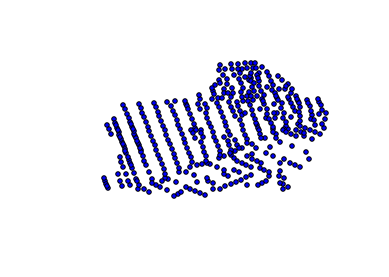

In [7]:
g0.plot(kind='scatter', x='lon', y='lat')
plt.axis('off')
plt.margins(0);

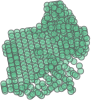

In [8]:
points = geometry.MultiPoint(zip(g0.lon, g0.lat))
points

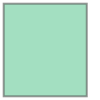

In [9]:
points.envelope

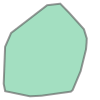

In [11]:
points.convex_hull

In [16]:
print points.convex_hull

POLYGON ((-122.4149262 37.774825, -122.4220135 37.7762879, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4220418 37.788951, -122.4203162 37.7929252, -122.4100267 37.8008532, -122.4062753 37.8012841, -122.4037825 37.7987246, -122.3995143 37.793989, -122.3987057 37.7913643, -122.3987545 37.7901007, -122.3989097 37.7882804, -122.4004581 37.7820199, -122.4027237 37.7766227, -122.4032342 37.7761656, -122.4116189 37.774997, -122.4149262 37.774825))


from http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/

In [137]:
from descartes import PolygonPatch
 
def plot_polygon(polygon):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
 
    x_min, y_min, x_max, y_max = polygon.bounds
 
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig
 
_ = plot_polygon(points.envelope)
_ = pl.plot(g0.lon,g0.lat,'o', color='#f16824')

AttributeError: 'numpy.ndarray' object has no attribute 'envelope'

In [19]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
 
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
 
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
 
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
 
    coords = np.array([point.coords[0]
                       for point in points])
 
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
 
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
 
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
 
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
 
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
 
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
 
concave_hull, edge_points = alpha_shape(points,
                                        alpha=1.87)

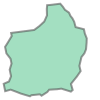

In [28]:
concave_hull, edge_points = alpha_shape(points, alpha=500)
concave_hull

In [31]:
print concave_hull

POLYGON ((-122.4027237 37.7766227, -122.4032342 37.7761656, -122.4059551 37.7770096, -122.4071553 37.7768534, -122.4094446 37.7767123, -122.4099949 37.7760366, -122.4116189 37.774997, -122.4121154 37.7753933, -122.4145362 37.7751339, -122.4149262 37.774825, -122.4175414 37.7756019, -122.4187254 37.7760734, -122.4204526 37.7767253, -122.4220135 37.7762879, -122.4221074 37.7767541, -122.4222006 37.7772211, -122.4222979 37.777686, -122.4224369 37.7783851, -122.4209256 37.7790538, -122.4203356 37.7805572, -122.4205364 37.7814964, -122.4207265 37.7824252, -122.4201965 37.7841648, -122.4202911 37.7846322, -122.4203824 37.785096, -122.4204843 37.785564, -122.4216637 37.787081, -122.4218532 37.788019, -122.4220418 37.788951, -122.4213657 37.790001, -122.4201373 37.792044, -122.4203162 37.7929252, -122.4186681 37.7931373, -122.4170253 37.7933484, -122.415667 37.7935219, -122.4148444 37.7936274, -122.413739 37.7937713, -122.4122756 37.7948638, -122.4108545 37.796174, -122.410556 37.7968362, -122

In [35]:
from descartes import PolygonPatch

(-122.425, -122.395, 37.769999999999996, 37.805)

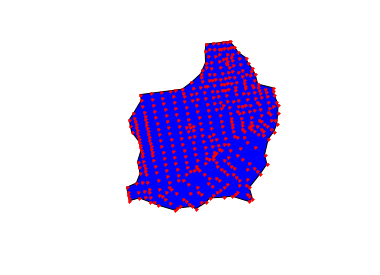

In [44]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(concave_hull, zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

In [82]:
gs = groups.group.unique()

polys = []
for g in gs:
    groupn = groups[groups.group == g]
    points = geometry.MultiPoint(zip(groupn.lon, groupn.lat))
    polygon, edge_points = alpha_shape(points, alpha=300)
    polys.append(polygon)

alpha 400 gives 'multipolygons', 300 is okay except for last one

In [83]:
polys

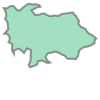

In [84]:
polys[0]

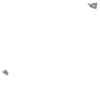

In [93]:
polys[-1]

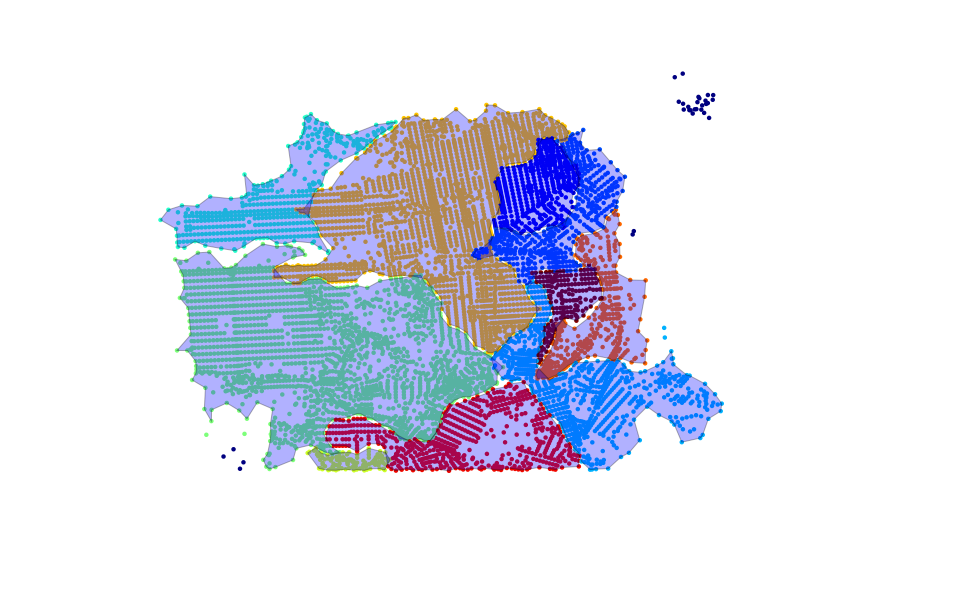

In [92]:
plt.figure(figsize=(16, 10))
plt.scatter(groups.lon, groups.lat, c=groups.group, linewidths=0)

ax = plt.gca()
for poly in polys[:-1]:
    patch = PolygonPatch(poly, zorder=1, alpha=0.3)
    ax.add_patch(patch)
plt.axis('equal')
plt.axis('off');

(-122.52, -122.38, 37.700000000000003, 37.82)

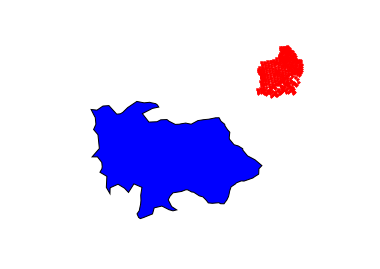

In [86]:
plt.figure()
plt.plot(g0.lon, g0.lat, 'r.')
ax = plt.gca()
patch = PolygonPatch(polys[0], zorder=2)
ax.add_patch(patch)
plt.axis('equal')
plt.axis('off')

# Make kml file

In [100]:
from fastkml import kml

In [103]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
p = kml.Placemark(ns, 'id', 'name', 'description')
p.geometry = polys[0]
f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [105]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
f = kml.Folder(ns, 'fid', 'f name', 'f description')
k.append(d)
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
for poly in polys[:-1]:
    p = kml.Placemark(ns, 'id', 'name', 'description')
    p.geometry = poly
    f2.append(p)
print k.to_string(prettyprint=True)

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>-122.501554,37.725265 -122.501621,37.722108 -122.503580,37.725489 -122.503292,37.731435 -122.507013,37.733629 -122.505968,37.735477 -122.505792,37.736585 

In [106]:
with open('test.kml', 'wb') as f:
    f.write(k.to_string())

# GeoJSON

In [3]:
import json
import matplotlib
from shapely.geometry import mapping, shape

from code.featurize import featurizer
from code.clusterize import cut2cluster, feature_bars
from code.shapes import make_polys

In [4]:
fdf = pickle.load(open('featuresdf.pkl', 'rb'))
cnum = cut2cluster('010405', 17)

# remove nodes with no connections
fdf = fdf.ix[cnum.index]

In [5]:
df = fdf.copy()
df['cnum'] = cnum
df = df[['lat', 'lon', 'cnum']]

/Users/crupley/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


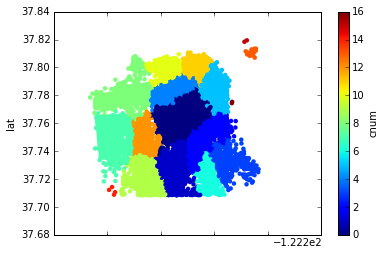

In [6]:
df.plot(kind='scatter', x='lon', y='lat', c='cnum', linewidths=0, cmap='jet')

In [7]:
polys = make_polys(df)

In [8]:
polys

In [9]:
len(polys)

17

In [10]:
jd = json.dumps(mapping(polys[0]))
print(jd)

{"type": "Polygon", "coordinates": [[[-122.4497124, 37.7386437], [-122.4511339, 37.7374936], [-122.4510653, 37.7399648], [-122.449965, 37.7422799], [-122.4493062, 37.7461032], [-122.4502214, 37.7521626], [-122.453141, 37.7531295], [-122.4543478, 37.7540775], [-122.4541041, 37.7560392], [-122.4531106, 37.7587055], [-122.4543702, 37.7613835], [-122.4571861, 37.7642874], [-122.4582901, 37.7648631], [-122.4594472, 37.7657366], [-122.4586481, 37.7666194], [-122.4569629, 37.7677016], [-122.454891, 37.769208], [-122.45378, 37.7717745], [-122.4532575, 37.7719981], [-122.4495459, 37.7720608], [-122.4464226, 37.7715089], [-122.4433158, 37.7728562], [-122.4420274, 37.7749318], [-122.4380828, 37.776388], [-122.4357807, 37.7776419], [-122.4341355, 37.7778515], [-122.4324908, 37.778061], [-122.4311415, 37.7782419], [-122.4276307, 37.7796412], [-122.4252785, 37.7799342], [-122.4229575, 37.7809491], [-122.4215388, 37.7820844], [-122.4200097, 37.7832341], [-122.4185821, 37.7843689], [-122.4167963, 37.7

In [11]:
geojson = {"type": "FeatureCollection",
           "features": [
            {"type": "Feature",
             "properties": {
                "color": "red"
            },
            "geometry": mapping(polys[0])
            }
    ]}

In [12]:
print json.dumps(geojson, indent=2, separators=(',', ': '))

{
  "type": "FeatureCollection",
  "features": [
    {
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -122.4497124,
              37.7386437
            ],
            [
              -122.4511339,
              37.7374936
            ],
            [
              -122.4510653,
              37.7399648
            ],
            [
              -122.449965,
              37.7422799
            ],
            [
              -122.4493062,
              37.7461032
            ],
            [
              -122.4502214,
              37.7521626
            ],
            [
              -122.453141,
              37.7531295
            ],
            [
              -122.4543478,
              37.7540775
            ],
            [
              -122.4541041,
              37.7560392
            ],
            [
              -122.4531106,
              37.7587055
            ],
            [
              -122.4543702,
 

In [13]:
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))

In [14]:
with open('results/geojsontest.json', 'wb') as f:
    json.dump(geojson, f)

In [15]:
c = matplotlib.cm.get_cmap('Set1')
clist = [matplotlib.colors.rgb2hex(rgb) for rgb in c(np.linspace(0,1,len(polys)))]
clist

[u'#e41a1c',
 u'#8d4c6a',
 u'#377eb8',
 u'#429780',
 u'#4eae4b',
 u'#737e77',
 u'#994fa1',
 u'#cd674f',
 u'#ff8101',
 u'#ffc11a',
 u'#fdfc33',
 u'#d1a72d',
 u'#a8572c',
 u'#d16d77',
 u'#f482be',
 u'#c58eab',
 u'#999999']

In [16]:
mapnos = ['010405' if i%2 == 0 else '010406' for i in range(len(polys)) ]
mapnos

['010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405',
 '010406',
 '010405']

In [17]:
fbars = feature_bars(fdf[['grocery', 'ncrimes', 'sgnf']], cnum)
print fbars.shape
fbars.head()

(17, 3)


,grocery,ncrimes,sgnf
cnum,,,
0,0.149822,0.041250,0.123031
1,-0.110202,-0.162532,0.268041
2,0.048199,-0.117082,0.143857
3,-0.063256,-0.101576,-0.125099
4,0.184782,0.045970,0.339135


In [18]:
fbars.ix[0].values.tolist()

[0.14982206307275842, 0.04124996513913315, 0.12303143745849965]

In [19]:
fnames = ['Grocery', 'Crime', 'Gender']

In [20]:
def list_(*args): return list(args)
map(list_, fnames, fbars.ix[0].values.tolist())

[['Grocery', 0.14982206307275842],
 ['Crime', 0.04124996513913315],
 ['Gender', 0.12303143745849965]]

In [21]:
# all polygons
featurelist = []
for i, poly in enumerate(polys):
    featurelist.append({"type": "Feature",
                        "properties": {
                        "color": clist[i],
                        "mapno": mapnos[i],
                        "neibno": i,
                        "bars" : map(list_, fnames, fbars.ix[i].values.tolist())
                        },
                        "geometry": mapping(poly)
                        })
    
geojson = {"type": "FeatureCollection",
           "features": featurelist}

In [22]:
print json.dumps(geojson, indent=2, separators=(',', ': '))

{
  "type": "FeatureCollection",
  "features": [
    {
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -122.4497124,
              37.7386437
            ],
            [
              -122.4511339,
              37.7374936
            ],
            [
              -122.4510653,
              37.7399648
            ],
            [
              -122.449965,
              37.7422799
            ],
            [
              -122.4493062,
              37.7461032
            ],
            [
              -122.4502214,
              37.7521626
            ],
            [
              -122.453141,
              37.7531295
            ],
            [
              -122.4543478,
              37.7540775
            ],
            [
              -122.4541041,
              37.7560392
            ],
            [
              -122.4531106,
              37.7587055
            ],
            [
              -122.4543702,
 

In [23]:
# human readable
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson, indent=2, separators=(',', ': ')))

In [24]:
# file size reduced to ~1/3
with open('results/geojsontest.json', 'wb') as f:
    f.write(json.dumps(geojson))

# Voronoi

In [35]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [50]:
points = np.array((fdf.lon, fdf.lat)).T
vor = Voronoi(points)

In [52]:
%matplotlib notebook

<IPython.core.display.Javascript object>


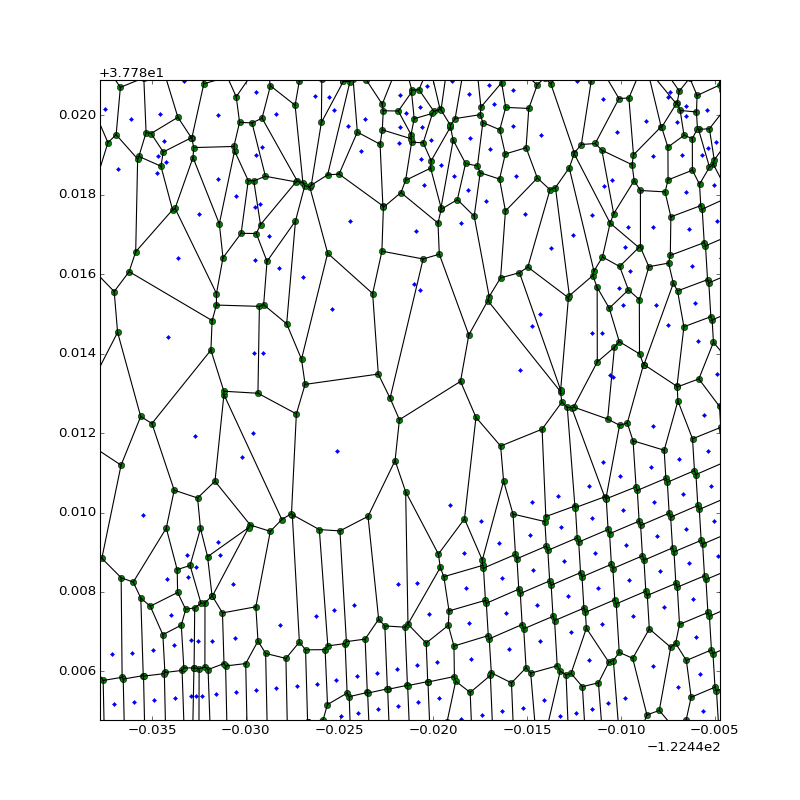

CPU times: user 31.9 s, sys: 2.22 s, total: 34.2 s
Wall time: 35 s


In [53]:
%%time
plt.figure(figsize=(10,10))
ax = plt.gca()
voronoi_plot_2d(vor, ax)
plt.show()

In [57]:
vor.vertices

array([[-122.35906553,   37.72598623],
       [-122.33655995,   37.77077438],
       [-122.49914235,   37.71640534],
       ..., 
       [-122.50569066,   37.75670672],
       [-122.50671114,   37.75663479],
       [-122.50676127,   37.7566594 ]])

In [59]:
np.array(vor.regions)

array([[20, 6, 5, -1, 0, 19], [24, -1, 5, 23], [37, 33, -1, 36], ...,
       [14578, 14234, 14235, 14236, 14556, 14576],
       [14579, 14268, 14420, 14423, 14234, 14578],
       [14580, 14561, 14233, 14269, 14268, 14579]], dtype=object)

In [60]:
vor.point_region

array([ 711,  678,  707, ..., 4176, 1828, 4179])

In [83]:
node = 0
verts = vor.vertices[vor.regions[vor.point_region[node]]]
verts

array([[-122.44157117,   37.74942594],
       [-122.4416337 ,   37.75051983],
       [-122.44064215,   37.75107571],
       [-122.44059616,   37.75102276],
       [-122.44050104,   37.7494826 ],
       [-122.44082679,   37.74911161],
       [-122.44111721,   37.74906621]])

* point_region - index of the region corresponding to point

In [62]:
%matplotlib inline

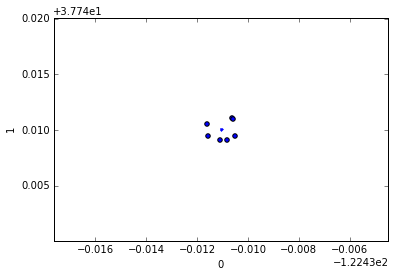

In [85]:
pd.DataFrame(verts).plot(kind='scatter', x=0, y=1)
plt.plot(df.lon[0], df.lat[0], '.')
plt.margins(0)

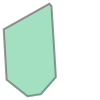

In [86]:
geometry.Polygon(verts)

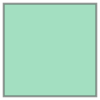

In [91]:
# test join polygons
pts1 = [[0,0], [0,1], [1,1], [1,0]]
poly1 = geometry.Polygon(pts1)
poly1

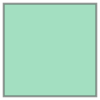

In [92]:
pts2 = [[1,0], [2,0], [2,1], [1,1]]
poly2 = geometry.Polygon(pts2)
poly2

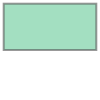

In [93]:
shapely.ops.cascaded_union([poly1, poly2])

In [94]:
polys = []
for region in vor.point_region:
    verts = vor.vertices[vor.regions[region]]
    polys.append(geometry.Polygon(verts))
    
len(polys)

7325

In [224]:
parr = np.array(polys)
parr.shape

(7325,)

In [225]:
# remove invalid polygons
validbool = map(lambda x: x.is_valid, parr)
parr = parr[validbool]
parr.shape

/Users/crupley/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()


(7325,)

In [227]:
sum(validbool)

7313

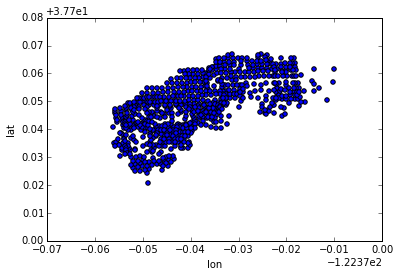

In [101]:
fdf[cnum == 2].plot(kind='scatter', x='lon', y='lat')

In [127]:
sub = pd.Series(parr)[np.array(cnum) == 2]
print sub.shape
sub.head()

(764,)


15    POLYGON ((-122.3884182304888 37.76178076341048...
16    POLYGON ((-122.3925838508023 37.75070323409192...
17    POLYGON ((-122.3911076616514 37.75313427996333...
18    POLYGON ((-122.3881295752724 37.74793797301871...
22    POLYGON ((-122.4104193248762 37.74111094679427...
dtype: object

In [148]:
%%time
group = shapely.ops.cascaded_union(list(sub))
group

CPU times: user 582 ms, sys: 13.7 ms, total: 596 ms
Wall time: 602 ms


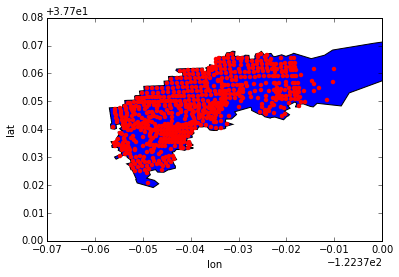

In [147]:
fdf[cnum == 2].plot(kind='scatter', x='lon', y='lat', c='red', linewidths=0)
patch = PolygonPatch(group, zorder=-1)
ax = plt.gca()
ax.add_patch(patch)

0
1
2
3

ERROR:shapely.geos:TopologyException: found non-noded intersection between LINESTRING (-122.357 37.7184, -122.507 37.7567) and LINESTRING (-122.365 37.7187, -122.364 37.7208) at -122.36446487699854 37.720253074049729


ValueError: No Shapely geometry can be created from null value

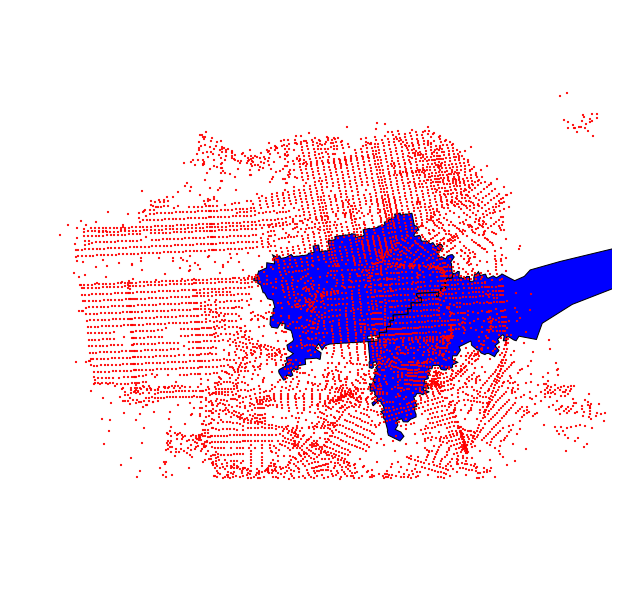

In [186]:

fdf.plot(kind='scatter', x='lon', y='lat', c='red', linewidths=0, figsize=(10,10), s=5)
plt.axis('equal')
plt.axis('off')
plt.margins(0)
ax = plt.gca()
for c in cnum.unique():
    print c
    sub = pd.Series(parr)[np.array(cnum) == c]
    group = shapely.ops.cascaded_union(list(sub))
    
    # skip plotting multipolygons for now
    if type(group) == shapely.geometry.multipolygon.MultiPolygon: continue
    patch = PolygonPatch(group, zorder=-1)
    ax.add_patch(patch)

In [199]:
u = geometry.Polygon()
for i, s in enumerate(sub):
    print i
    u = u.union(s)
u

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ERROR:shapely.geos:TopologyException: side location conflict at -122.36446487699854 37.720253074049729



367
368


TopologicalError: The operation 'GEOSUnion_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x13ecdcb50>

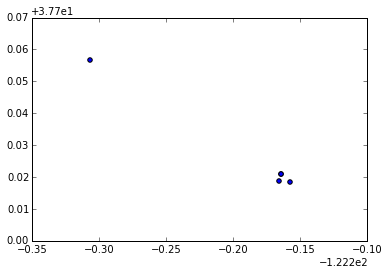

In [216]:
plt.scatter(*zip(*list(s.exterior.coords)))

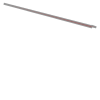

In [217]:
s

In [218]:
s.is_valid

False

In [223]:
sum(map(lambda x: x.is_valid, parr))

7313